# Analyzing Twitter US Airline Sentiment

In this notebook, I'll be building a model (inspired by Bert Carremans' [here](https://towardsdatascience.com/handling-overfitting-in-deep-learning-models-c760ee047c6e#:~:text=Overfitting%20occurs%20when%20you%20achieve,are%20irrelevant%20in%20other%20data.&text=The%20best%20option%20is%20to%20get%20more%20training%20data)) to do some sentiment analysis. The dataset I'll be using is Kaggle's [Twitter US Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). According to Kaggle, this was a sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

I will also discuss overfitting as a problem within ML models and how regularization techniques can be used to combat this.




## Loading and Processing Data

First, I will download the dataset from Kaggle and begin processing the data.

## Downloading Data From Kaggle

Here, I've gone through some configurations to allow direct download from Kaggle's API.

In [3]:
# !pip install -q kaggle
# !pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d crowdflower/twitter-airline-sentiment -p /content/sample_data
!unzip sample_data/twitter-airline-sentiment.zip

!rm sample_data/twitter-airline-sentiment.zip
!rm database.sqlite
!mv Tweets.csv sample_data/

{"username":"natasharavinand","key":"3ae1b381c5c2b0543ea78ac07b2b645d"}Downloading twitter-airline-sentiment.zip to /content/sample_data
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 85.4MB/s]
Archive:  sample_data/twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


Now, I'll go ahead and import some necessary packages that will let us preprocess as well as build the model. I'll be using Keras/Tensorflow.

In [4]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

I'll also be choosing some parameters.

In [5]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 30  # Number of epochs we usually start to train with
BATCH_SIZE = 500  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 15  # Maximum number of words in a sequence

### Data Cleaning

One of the most important parts of a data science project is cleaning the data. We'll perform a random shuffle first, so the sentiment classes are equally distributed over the training and testing set. We'll only keep the `text` column as input and the `airline_sentiment` column as the target.

Next, we'll remove stopwords. In NLP, stopwords are words that do not have value in predicting the sentiment. Lastly, we'll remove the mentions so this model can be used for multiple airline companies. We'll define functions (from Bert's article) `remove_stopwords` and `remove_mentions` to help with this. 

In [6]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.Name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.Name)
    plt.plot(e, metric_model_2, 'b', label=model_2.Name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [7]:
df = pd.read_csv('sample_data/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We see that the data includes information on:

- Airline sentiment
- Negative reason, if any
- Tweet ID
- Airline
- Name

In [9]:
nltk.download('stopwords')

df = df.reindex(np.random.permutation(df.index)) # shuffle tweets
df = df[['text', 'airline_sentiment']] # only keep two columns
df.text = df.text.apply(remove_stopwords).apply(remove_mentions) # remove stopwords and mentions using helper function

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Train-Test Split

We now split the data into training and testing.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)

### Converting Words to Numbers

We need to convert words into tokens, which means that we convert the words to integers that refer to an index in a dictionary. Here, we will only keep the most frequent words in the training set. We'll apply filters to clean up the text and make the words all lower case, with words separated by spaces.

We'll use `Tokenizer` to do this.

In [11]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

Now that we've created our "token dictionary", we'll convert the text of a tweet to a vector with our previously defined `NB_WORDS` values. `mode=binary` contains an indicator as to whether the word appeared in the tweet or not.

In [12]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

### Converting Target Classes to Numbers

We will now use a `LabelEncoder()` and `to_categorical` (one-hot encoding) to convert the target classes to numbers as well.

In [13]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

### Creating a Validation Set

We can now split off a validation set. A validation set is used to evaluate the models performance when we tune the parameters of the model. Notice we use the one hot encoded version of the X and y training sets.

In [14]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

## Deep Learning

### Creating an Overfitting Model

Let's explore how we can overcome overfitting by first creating a model that purposely overfits. We'll define a model architecture of 2 densely connected layers of 64 neurons. The `input_shape` for the first layer is equal to the <i>number of words we kept in the dictionary and for which we created one-hot-encoded features</i>.

The last layer must have 3 output neurons, as we want to predict 3 different sentiment classes. We'll use the `softmax` activation function as it makes sure the three probabilities will sum up to 1.

As Bert lays out:

The number of parameters to train is computed as (nb inputs x nb elements in hidden layer) + nb bias terms. The number of inputs for the first layer equals the number of words in our corpus. The subsequent layers have the number of outputs of the previous layer as inputs. So the number of parameters per layer are:

- First layer : (10000 x 64) + 64 = 640064
- Second layer : (64 x 64) + 64 = 4160
- Last layer : (64 x 3) + 3 = 195

We'll use `Sequential()` from Keras to define the model.

In [15]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.Name = 'Baseline model'

This project is a multi-class, single-label prediction, so we can use `categorical_crossentropy` as the loss function and `softmax` as the final activation function. We'll fit the model on the train data and validate on the validation set to tune our parameters. We'll run over our set amount of epochs and see when the model starts to overfit; i.e., when validation accuracy starts to suddenly plummet.

Minimum validation loss reached in epoch 3


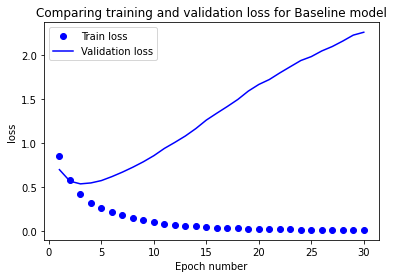

In [16]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

We observe that validation loss, in the beginning, is decreasing. But by the 4th epoch, this stops and then the loss begins to decrease rapidly while the train loss approaches 0. 

## Handling Overfitting

We can try 3 different approaches to combat overfitting:

- Reduce the network’s capacity by removing layers or reducing the number of elements in the hidden layers
- Apply regularization, which comes down to adding a cost to the loss function for large weights
- Use Dropout layers, which will randomly remove certain features by setting them to zero

### Reducing the Network's Capacity

The higher the number of trainable parameters, the easier the model can memorize the target for each training sample. This doesn't generalize well on new data. By reducing the capacity of the network, we "force" it to learn patterns rather than memorize data.

However, we don't want to reduce the model's capacity by <i>too</i> much. This will lead to underfitting.

We'll reduce the network's capacity by removing one hidden layer and lowering the number of neurons in the remaining layer to 16.

Minimum validation loss reached in epoch 11


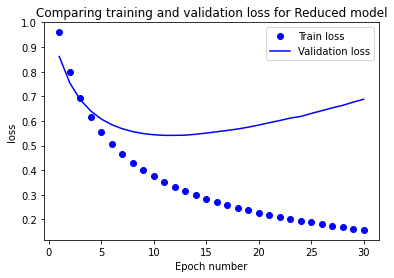

In [17]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.Name = 'Reduced model'
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

We see that it takes almost 3 times as many epochs for the model to show signs of overfitting. The validation loss also goes up more slowly than the previous model.

We can use one of Bert's helper functions to compare the models by metric.

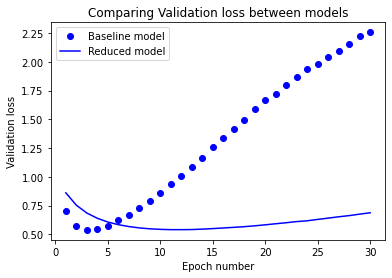

In [18]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

We see that when we compare the validation loss of the previous model, its cleaer that the second model starts overfitting at a later epoch.

### Applying Regularization

We can also apply a weight regularization to the model. This adds a cost to the loss function of the network for large weights or parameter values. Thus, we get a simpler model that will be forced to learn only relevant patterns in the train data rather than ALL patterns, and thus won't overfit as much.

There are two kinds of regularization: L1 and L2.

- <b>L1 regularization</b> will add a cost with regards to the absolute value of the parameters. It will result in some of the weights to be equal to zero.
- <b>L2 regularization</b> will add a cost with regards to the squared value of the parameters. This results in smaller weights.

We'll use L2 regularization here. Notice that we haven't changed the model architecture.

In [19]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.Name = 'L2 Regularization model'
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 4


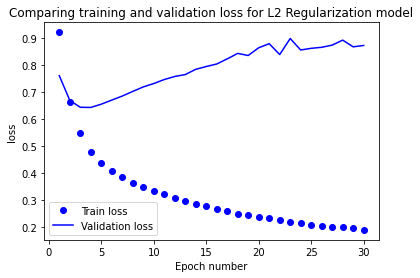

In [20]:
eval_metric(reg_model, reg_history, 'loss')

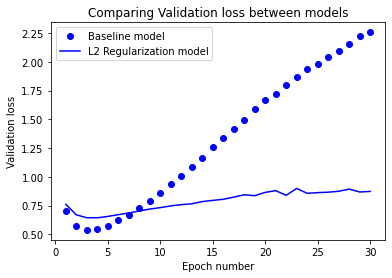

In [21]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

We notice that the regularized model starts overfitting in the same epoch as the baseline model, but the validation loss increases more slowly.

### Adding Dropout Layers

Lastly, we can use dropout layers to randomly set output features of a layer to zero. This will let the model not rely on any one neuron in its predictions.

Minimum validation loss reached in epoch 5


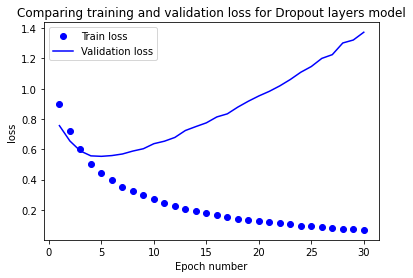

In [23]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.Name = 'Dropout layers model'

drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

We see that the model with dropout layers begins to overfit layer than the baseline, and the loss also increases at a slower rate.

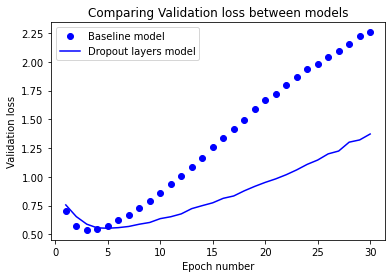

In [24]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')


We see that the baseline model experiences a validation loss that is much higher as the epochs go up.

### Evaluating on Testing Set

It seems that the reduced model perform best in reducing overfitting. Let's verify this on the test set.

In [25]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min) #baseline model

reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min) #reduced model

reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min) #l2 reg

drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min) #drouput

46/46 [==============================] - 0s 3ms/step - loss: 1.2000 - accuracy: 0.7596

Test accuracy: 75.96%
46/46 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.7835

Test accuracy: 78.35%
46/46 [==============================] - 0s 3ms/step - loss: 0.8168 - accuracy: 0.7787

Test accuracy: 77.87%
46/46 [==============================] - 0s 2ms/step - loss: 0.9919 - accuracy: 0.7889

Test accuracy: 78.89%


We see that the model actually performs best with dropout layers.